# Imbalanced classes

## The problem of inbalance
Imbalance in classification problem is a fairly common issue. We meet this problem in many fields, for example:
* Credit defaults
* Churn analysis
* Fraud detection
* Advertising campaigns
* Spam filtering

Working with imbalanced classes can be very problematic for several reasons:
* Interpretation of metrics. A typical example is a dataset for binary classification in which we have balance 99:1. In this case it is very easy to get “good results” for most metrics (Accuarcy/AUC/etc). One must take the balance of the dataset into consideration when interpretating metrics.
* Effect of imbalance on the loss function. When we train our model on the complete, imbalanced dataset this affects the loss function and therefore the optimizer and the resulting estimator as well. Strong imbalance may lead to disregarding the minority class by an optimizer as it will almost always get more gains in terms of the loss function by “focusing on the majority class” then on the minority class.


## Working with imbalanced dataset
One can say that the only way to fight imbalance is ... changing the balance. In general there are three ways to do this and fight the problem of imbalance. 
* Undersampling
* Oversampling
* Modification of the opitmizer/loss function
Each of the above results in re-weighting of the classes. Either on the level of data or on the level of optimizer/loss function. The general idea however is the same.

### Undersampling
One way the make the problem more balanced is to remove some of the observations in the majority class. The question is, which observations should be removed? We can do it in many ways. Three most common are:
* Undersample clusters of majority class
* Remove observations from majority class that are “near” the minority class / decision boundry.
* Undersample the majority class by removing the observations that are “easy” to predict.

#### Unersampling with Cluster-Centroids
In this approach we will use k-NN to find small clusters of observations in majority class. Later we will remove all the observations but the centroid from all the clusters. We set the number of  clusters so that it is equal to the number of observations that we want to keep in the majority class.

#### Tomek link 
In Tomek link observations from majority class are iteratively removed until all minimally distanced pairs of observations are in the same class. In this approach if there are observations from majority class that are “near” observations from minority class we remove them to “give more wieght” to this part of space to minority class.

#### Iterative undersampling
Most algorithms output probibilites and not just predictions.  When we analyze ROC we see that usually there are some observations that are “easy” to predict. Very often we can correctly predict large share of observations from majority class without any false positives and negatives. We can iteratively undersample by removing these parts of observations in majority class that are get the highest probabilities.


### Oversampling
Oversampling works be creating additional, synthetic observations in minority class.
* Random sampling
* SMOTE -  Synthetic Minority Oversampling Technique
* ADASYN - Adaptive Synthetic

#### Random sampling
There are many variants of random over sampling. The simplest possible way is to randomly draw observations from minority class (with replacement) and duplicate drawn observations. We can modify/extend this method by adding some noise to features (based on their distribution) to duplicated observations.

#### SMOTE
The general idea behind smote is to create new synthetic observations that are linear combinations of nearest neighbours of pair of observations in the minority class. There are many variants and specific implementation, but the general idea stays the same. This way of oversampling forces the estimator  to be more general around the minority class.


#### ADASYN
ADASYN is, in a way, an extension of SMOTE. In this approach we try to create more synthetic examples for those observations in minority class that are “harder” to predict. In the first stage we run simple k-NN classifier for every observation in minority class and create new, synthetic observations based on the predicted probability. More synthetic observations are created when the probability of correct prediction is lower.


### Summary
* Over/undersampling usually doesn't work. No technique can create additional "true" information in the dataset out of thin air.
* Different solutions for under/oversampling may work with different datasets and algorithms.
* Proper CV is extremly important in imbalance problem as it is prone to leakage.
* When working with imbalanced dataset, a model with worse result in regular metric (for example AUC) can be actualy better from the business point of view. This may be the case, for example, when the "real" cost function is asymmetric.
* There are many ways to under and oversample. Methods mentioned above are well known examples. [see here](https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/README.rst#about)

In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

import gc

We will work with german credit scroe dataset. The class is imbalanced 7:3 in the original dataset.

In [4]:
german = pd.read_csv('data/german1.csv', delimiter=',', low_memory=False)
german.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v16,v17,v18,v19,v20,v21,v22,v23,v24,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


In [5]:
german["target"]=german["target"]-1
german.head()
features = german.columns.tolist()
print(features)
features.remove('target')
german[features] = german[features].apply(lambda x: (x-x.mean())/x.std())

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'target']


In [6]:
german.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v16,v17,v18,v19,v20,v21,v22,v23,v24,target
0,-1.253938,-1.235859,1.343342,-0.733065,1.832252,1.337409,0.449102,1.046463,-1.293076,2.765073,...,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973,0
1,-0.458797,2.247070,-0.503176,0.965893,-0.699357,-0.317800,-0.963168,-0.765594,-1.293076,-1.190808,...,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973,1
2,1.131486,-0.738298,1.343342,-0.414510,-0.699357,0.509805,0.449102,0.140434,-1.293076,1.182721,...,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224,0
3,-1.253938,1.749509,-0.503176,1.638398,-0.699357,0.509805,0.449102,1.046463,-0.340885,0.831087,...,-0.552429,-0.338692,-3.121368,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973,0
4,-1.253938,0.256825,0.420083,0.576549,-0.699357,-0.317800,0.449102,1.046463,1.563498,1.534354,...,1.808378,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973,1


We start by splitting the complete dataset into training and valdiation sets.

In [7]:
from sklearn.model_selection import train_test_split
test_size = 0.3
gTrain, gValid = train_test_split(german, test_size=test_size, random_state=2017, stratify=german["target"].values)

In [8]:
print(gTrain.target.value_counts())
print(gValid.target.value_counts())

0    490
1    210
Name: target, dtype: int64
0    210
1     90
Name: target, dtype: int64


### Dataset preparation
Now we will prepare two more datasets with stronger imbalance by removing some of target variables equal to 1. We do this to both training and validation datasets.

**WARNING!** The number of observation with target==1 for imbalanced datasets is very small. We should run the notebook several times to check the stability of results.

In [5]:
trainIndex1 = list(gTrain.query("target==1").index.values)
validIndex1 = list(gValid.query("target==1").index.values)
from random import shuffle
shuffle(trainIndex1)
shuffle(validIndex1)

In [6]:
gTrain10 = gTrain.drop(trainIndex1[0:140])
gTrain20 = gTrain.drop(trainIndex1[0:70])
gValid10 = gValid.drop(validIndex1[0:60])
gValid20 = gValid.drop(validIndex1[0:30])

In [7]:
print(gTrain20.target.value_counts())
print(gValid20.target.value_counts())

print(gTrain10.target.value_counts())
print(gValid10.target.value_counts())

0    490
1    140
Name: target, dtype: int64
0    210
1     60
Name: target, dtype: int64
0    490
1     70
Name: target, dtype: int64
0    210
1     30
Name: target, dtype: int64


### Benchmarks
First lets run the benchmark for simple logistic regression with any under/oversampling. For reference point lets plot the ROC for one of the sets.

In [8]:
from sklearn import metrics
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrain.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

Train AUC: 0.8289698736637513 Valid AUC: 0.7794708994708995


In [9]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

Train AUC: 0.8348104956268223 Valid AUC: 0.7194444444444444


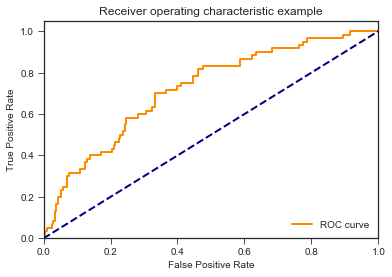

In [10]:
from sklearn.metrics import roc_curve
fprNS, tprNS, _ = roc_curve(gValid20.target, preds)
plt.figure()
lw = 2
plt.plot(fprNS, tprNS, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, preds))

Train AUC: 0.8758309037900875 Valid AUC: 0.6941269841269841


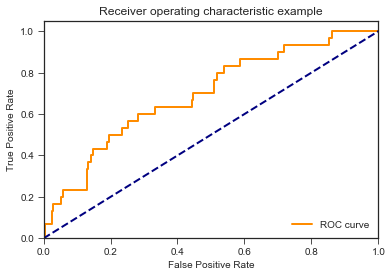

In [12]:
from sklearn.metrics import roc_curve
fprNS2, tprNS2, _ = roc_curve(gValid10.target, preds)
plt.figure()
lw = 2
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Undersampling
Lets start with random undersampling with simple random undersampling. 

In [13]:
trainIndex0 = list(gTrain.query("target==0").index.values)
shuffle(trainIndex1)
gTrainUrandom = gTrain.drop(trainIndex0[0:90])
gTrain10Urandom = gTrain10.drop(trainIndex0[0:90])
gTrain20Urandom = gTrain20.drop(trainIndex0[0:90])

In [14]:
from sklearn import metrics
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainUrandom, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainUrandom.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20Urandom, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20Urandom.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10Urandom, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsU = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10Urandom.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, predsU))

Train AUC: 0.8281428571428572 Valid AUC: 0.7733862433862434
Train AUC: 0.8340892857142856 Valid AUC: 0.7092063492063492
Train AUC: 0.8737142857142858 Valid AUC: 0.6942857142857143


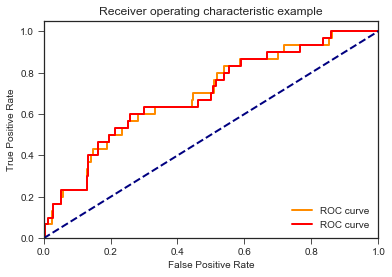

In [15]:
from sklearn.metrics import roc_curve
# fprNS2, tprNS2, _ = roc_curve(gValid10.target, preds)
fprNS3, tprNS3, _ = roc_curve(gValid10.target, predsU)
plt.figure()
lw = 2
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS3, tprNS3, color='red',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Clusters Centroids
As expected Random undersampling did not help too much. Next in line to test is ClusterCentroids algorithm.

In [16]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(ratio={0:400, 1:210}, random_state=42)
X_resampled, y_resampled = cc.fit_sample(gTrain[features], gTrain.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrainUCC = df.copy()
print(gTrainUCC.shape)

cc = ClusterCentroids(ratio={0:400, 1:140}, random_state=42)
X_resampled, y_resampled = cc.fit_sample(gTrain20[features], gTrain20.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain20UCC = df.copy()
print(gTrain20UCC.shape)

cc = ClusterCentroids(ratio={0:400, 1:70}, random_state=42)
X_resampled, y_resampled = cc.fit_sample(gTrain10[features], gTrain10.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain10UCC = df.copy()
print(gTrain10UCC.shape)

c:\programy\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(610, 25)
(540, 25)
(470, 25)


In [17]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainUCC, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainUCC.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20UCC, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20UCC.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10UCC, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsCC = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10UCC.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, predsCC))

Train AUC: 0.8219642857142857 Valid AUC: 0.7726984126984128
Train AUC: 0.8274107142857142 Valid AUC: 0.7215873015873016
Train AUC: 0.868 Valid AUC: 0.6920634920634922


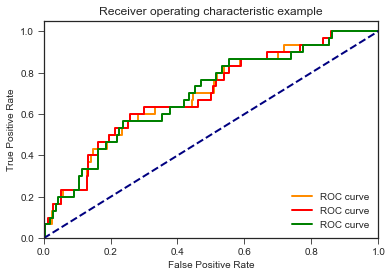

In [18]:
from sklearn.metrics import roc_curve
fprNS4, tprNS4, _ = roc_curve(gValid10.target, predsCC)
plt.figure()
lw = 2
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS3, tprNS3, color='red',
         lw=lw, label='ROC curve')
plt.plot(fprNS4, tprNS4, color='green',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### TomekLinks

In [19]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(ratio={0:400, 1:210}, random_state=42)
X_resampled, y_resampled = tl.fit_sample(gTrain[features], gTrain.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrainUTL = df.copy()
print(gTrainUTL.shape)

tl = TomekLinks(ratio={0:400, 1:140}, random_state=42)
X_resampled, y_resampled = tl.fit_sample(gTrain20[features], gTrain20.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain20UTL = df.copy()
print(gTrain20UTL.shape)

tl = TomekLinks(ratio={0:400, 1:70}, random_state=42)
X_resampled, y_resampled = tl.fit_sample(gTrain10[features], gTrain10.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain10UTL = df.copy()
print(gTrain10UTL.shape)

(608, 25)
(558, 25)
(514, 25)


In [20]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainUTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainUTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20UTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20UTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10UTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsTL = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10UTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, predsTL))

Train AUC: 0.8543039991210722 Valid AUC: 0.7792063492063492
Train AUC: 0.8567434767875298 Valid AUC: 0.7085714285714286
Train AUC: 0.8973529545765183 Valid AUC: 0.6601587301587303


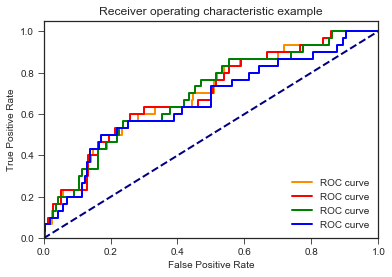

In [21]:
from sklearn.metrics import roc_curve
fprNS5, tprNS5, _ = roc_curve(gValid10.target, predsTL)
plt.figure()
lw = 2
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS3, tprNS3, color='red',
         lw=lw, label='ROC curve')
plt.plot(fprNS4, tprNS4, color='green',
         lw=lw, label='ROC curve')
plt.plot(fprNS5, tprNS5, color='blue',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Iterative undersampling
**Reminder** In some cases (depending on the split and random draw in removal of observations) with different algorithms and somtetimes not.

In [23]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
gTrainUIT = gTrain.copy()
gTrainUIT["probs1"]=predsTrain
print(gTrainUIT.shape)
gTrainUIT = gTrainUIT.query("probs1>0.05")
print(gTrainUIT.shape)
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainUIT, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsa = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainUIT.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, predsa))


mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
gTrain20UIT = gTrain20.copy()
gTrain20UIT["probs1"]=predsTrain
print(gTrain20UIT.shape)
gTrain20UIT = gTrain20UIT.query("probs1>0.15")
print(gTrain20UIT.shape)
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20UIT, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsb = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20UIT.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, predsb))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
gTrain10UIT = gTrain10.copy()
gTrain10UIT["probs1"]=predsTrain
print(gTrain10UIT.shape)
gTrain10UIT = gTrain10UIT.query("probs1>0.25")
print(gTrain10UIT.shape)
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10UIT, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
predsIU = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10UIT.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, predsIU))

(700, 26)
(610, 26)
Train AUC: 0.8002894182931496 Valid AUC: 0.7774603174603174
(630, 26)
(302, 26)
Train AUC: 0.7298269581056466 Valid AUC: 0.7267460317460317
(560, 26)
(94, 26)
Train AUC: 0.7591836734693878 Valid AUC: 0.6195238095238096


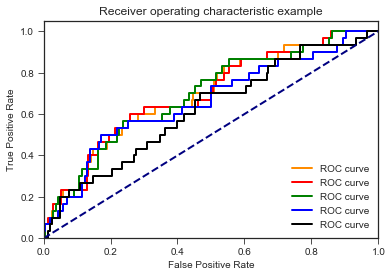

In [24]:
from sklearn.metrics import roc_curve
fprNS6, tprNS6, _ = roc_curve(gValid10.target, predsIU)
plt.figure()
lw = 2
plt.plot(fprNS2, tprNS2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS3, tprNS3, color='red',
         lw=lw, label='ROC curve')
plt.plot(fprNS4, tprNS4, color='green',
         lw=lw, label='ROC curve')
plt.plot(fprNS5, tprNS5, color='blue',
         lw=lw, label='ROC curve')
plt.plot(fprNS6, tprNS6, color='black',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Oversampling
### SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(ratio={0:490, 1:300}, random_state=42)
X_resampled, y_resampled = smt.fit_sample(gTrain[features], gTrain.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrainOSM = df.copy()
print(gTrainOSM.shape)

smt = SMOTE(ratio={0:490, 1:210}, random_state=42)
X_resampled, y_resampled = smt.fit_sample(gTrain20[features], gTrain20.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain20OSM = df.copy()
print(gTrain20OSM.shape)

smt = SMOTE(ratio={0:490, 1:140}, random_state=42)
X_resampled, y_resampled = smt.fit_sample(gTrain10[features], gTrain10.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain10OSM = df.copy()
print(gTrain10OSM.shape)

(790, 25)
(700, 25)
(630, 25)


In [26]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainUTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainUTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20UTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20UTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10UTL, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10UTL.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, preds))

Train AUC: 0.8543039991210722 Valid AUC: 0.7792063492063492
Train AUC: 0.8567434767875298 Valid AUC: 0.7085714285714286
Train AUC: 0.8973529545765183 Valid AUC: 0.6601587301587303


### ADASYN

In [27]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(ratio={0:490, 1:300}, random_state=42)
X_resampled, y_resampled = ada.fit_sample(gTrain[features], gTrain.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrainOADA = df.copy()
print(gTrainOADA.shape)

ada = ADASYN(ratio={0:490, 1:210}, random_state=42)
X_resampled, y_resampled = ada.fit_sample(gTrain20[features], gTrain20.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain20OADA = df.copy()
print(gTrain20OADA.shape)

ada = ADASYN(ratio={0:490, 1:140}, random_state=42)
X_resampled, y_resampled = ada.fit_sample(gTrain10[features], gTrain10.target)
df = pd.DataFrame(X_resampled, columns=features)
df["target"] = y_resampled
gTrain10OADA = df.copy()
print(gTrain10OADA.shape)

(774, 25)
(694, 25)
(629, 25)


Train AUC: 0.8093489508479448 Valid AUC: 0.7684126984126984
Train AUC: 0.8290116046418567 Valid AUC: 0.7188888888888889


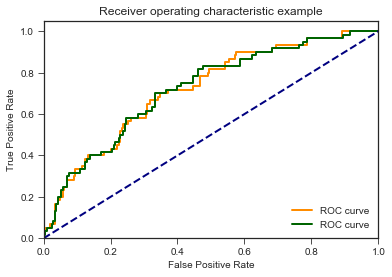

Train AUC: 0.8957568638966378 Valid AUC: 0.6890476190476191


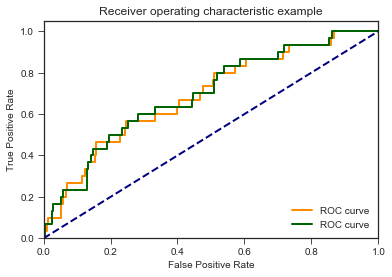

In [28]:
mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrainOADA, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid)
print("Train AUC:", metrics.roc_auc_score(gTrainOADA.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid.target, preds))

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain20OADA, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid20)
print("Train AUC:", metrics.roc_auc_score(gTrain20OADA.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid20.target, preds))

fpr, tpr, _ = roc_curve(gValid20.target, preds)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS, tprNS, color='darkgreen',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mod = sm.GLM.from_formula(formula="target ~ " + "+".join(features), data=gTrain10OADA, family=sm.families.Binomial())
res = mod.fit()
predsTrain = res.predict()
preds = res.predict(gValid10)
print("Train AUC:", metrics.roc_auc_score(gTrain10OADA.target, predsTrain),
      "Valid AUC:", metrics.roc_auc_score(gValid10.target, preds))

fpr, tpr, _ = roc_curve(gValid10.target, preds)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fprNS2, tprNS2, color='darkgreen',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()